In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [3]:
df_train           = pd.read_csv("train_aWnotuB.csv")
df_test            = pd.read_csv("test_BdBKkAj.csv")

In [4]:
print("Size of training set: "+ str(df_train.shape))
print("Size of test set: "+ str(df_test.shape))
print('\n')
print('columns in train: '+str(df_train.columns.tolist()))
print('columns in test: '+str(df_test.columns.tolist()))

df_train.head()

Size of training set: (48120, 4)
Size of test set: (11808, 3)


columns in train: ['DateTime', 'Junction', 'Vehicles', 'ID']
columns in test: ['DateTime', 'Junction', 'ID']


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [5]:
# Quick EDA
# lag_features
train = df_train.pivot(index='DateTime', columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


In [6]:
train.isnull().sum()

Junction
1        0
2        0
3        0
4    10248
dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14592 entries, 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       14592 non-null  float64
 1   2       14592 non-null  float64
 2   3       14592 non-null  float64
 3   4       4344 non-null   float64
dtypes: float64(4)
memory usage: 570.0+ KB


In [8]:
value=round(train[4].max())/1.0
value

36.0

In [9]:
train = train.fillna(value)

In [10]:
# Generate lag features

def gen_lag_features(df, n_in=1,n_out=1,dropnan=True):
    n_vars = df.shape[1]
    cols, names = list(), list()
    #input sequence (t-n,.....t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[('Junction %d (H-%d)' %(j+1, i)) for j in range(n_vars)]
    # forecast sequence (t,t+1,.....t+n)
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names+=[('Junction %d (H)' %(j+1)) for j in range(n_vars)]
        else:
            names+=[('Junction %d (H+%d)' %(j+1,i)) for j in range(n_vars)]
    #put it all together
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
Xy_train= gen_lag_features(train)
Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,15.0,6.0,9.0,36.0,13.0,6.0,7.0,36.0
2015-11-01 02:00:00,13.0,6.0,7.0,36.0,10.0,5.0,5.0,36.0
2015-11-01 03:00:00,10.0,5.0,5.0,36.0,7.0,6.0,1.0,36.0
2015-11-01 04:00:00,7.0,6.0,1.0,36.0,9.0,7.0,2.0,36.0
2015-11-01 05:00:00,9.0,7.0,2.0,36.0,6.0,2.0,2.0,36.0
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,95.0,34.0,38.0,17.0,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,105.0,34.0,33.0,11.0,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,96.0,35.0,31.0,30.0,90.0,31.0,28.0,16.0


In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))
Xy_train[Xy_train.columns]= scaler.fit_transform(Xy_train[Xy_train.columns])

Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,1.000000,0.052980,0.106383,0.033520,1.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,1.000000,0.033113,0.085106,0.022346,1.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,1.000000,0.013245,0.106383,0.000000,1.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,1.000000,0.026490,0.127660,0.005587,1.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,1.000000,0.006623,0.021277,0.005587,1.000000
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.457143,0.662252,0.702128,0.178771,0.285714
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.285714,0.602649,0.723404,0.167598,0.828571
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.828571,0.562914,0.638298,0.150838,0.428571


In [13]:
# Split train and valid (and normalize for real)
X_train = Xy_train[Xy_train.index < '2017-04-01'].iloc[:,0:4]
X_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,1.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,1.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,1.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,1.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,1.000000
...,...,...,...,...
2017-03-31 19:00:00,0.476821,0.574468,0.178771,0.142857
2017-03-31 20:00:00,0.496689,0.531915,0.156425,0.200000
2017-03-31 21:00:00,0.483444,0.638298,0.156425,0.200000


In [14]:
y_train= Xy_train[Xy_train.index < '2017-04-01'].iloc[:,4:]
y_train

,Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,
2015-11-01 01:00:00,0.052980,0.106383,0.033520,1.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,1.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,1.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,1.000000
2015-11-01 05:00:00,0.006623,0.021277,0.005587,1.000000
...,...,...,...,...
2017-03-31 19:00:00,0.496689,0.531915,0.156425,0.200000
2017-03-31 20:00:00,0.483444,0.638298,0.156425,0.200000
2017-03-31 21:00:00,0.403974,0.574468,0.150838,0.228571


In [15]:
# Reshape the Data

print(X_train.shape, y_train.shape)

(12407, 4) (12407, 4)


In [16]:
X_train = np.expand_dims(X_train.values,axis=2)
print(X_train.shape)

y_train= y_train.values
print(y_train.shape)

(12407, 4, 1)
(12407, 4)


In [17]:
# Keras Recurrent NN modeling
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.initializers import he_normal
import keras.backend as K

def root_mean_squared_error(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [18]:
# Initialising the RNN
regressor= Sequential()

#Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50,activation='relu',kernel_initializer= he_normal(seed=0),input_shape=(None,1)))

#output for 4 junctions
regressor.add(Dense(units=4))

#Compiling the RNN
regressor.compile(optimizer='adam',loss= root_mean_squared_error)

C:\Users\ABC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
import tensorflow as tf

def root_mean_squared_error(y_true, y_pred):
    return tf.math.sqrt(tf.reduce_mean(tf.square(y_pred - y_true), axis=-1))


In [22]:
# Compiling the RNN
regressor.compile(optimizer='adam', loss=root_mean_squared_error)

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size=120, epochs=100, verbose=1)


Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1725
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0383
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0361
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0350
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0333
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0330
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0326
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0320
Epoch 9/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0320
Epoch 10/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0327
Epoch 11/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326
Epoch 12/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0323
Epoch 13/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0323
Epoch 14/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0319
Epoch 15/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1

In [23]:
# Validating
X_valid = Xy_train[Xy_train.index >='2017-04-01'].iloc[:,0:4]
X_valid

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2017-04-01 00:00:00,0.417219,0.553191,0.162011,0.142857
2017-04-01 01:00:00,0.384106,0.510638,0.122905,0.142857
2017-04-01 02:00:00,0.317881,0.574468,0.078212,0.114286
2017-04-01 03:00:00,0.238411,0.361702,0.083799,0.085714
2017-04-01 04:00:00,0.225166,0.361702,0.055866,0.085714
...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.457143
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.285714
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.828571


In [24]:
X_valid=np.expand_dims(X_valid.values,axis=2)
y_pred= regressor.predict(X_valid) 

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [25]:
# I rescale y in the integer count range
# to do that we must first reconcatenate with the X data as scaler expects a shape of 8

y_pred = scaler.inverse_transform(np.concatenate((X_valid.squeeze(), y_pred),axis=1))[:,4:]
y_pred

array([[67.92810905, 25.17389518, 26.25073662,  7.39041297],
       [61.55781725, 23.38969707, 20.09662659,  6.6800089 ],
       [50.54355446, 23.51020849, 12.50346395,  4.42751868],
       ...,
       [89.86501157, 29.63168567, 26.28406197, 27.85463876],
       [85.00452483, 28.33340758, 25.63983244, 12.18612885],
       [80.4582206 , 26.21176744, 22.8925827 , 18.34296307]])

In [26]:
y_truth= train[train.index >= '2017-04-01']
y_truth

Junction,1,2,3,4
DateTime,,,,
2017-04-01 00:00:00,63.0,25.0,23.0,6.0
2017-04-01 01:00:00,53.0,28.0,15.0,5.0
2017-04-01 02:00:00,41.0,18.0,16.0,4.0
2017-04-01 03:00:00,39.0,18.0,11.0,4.0
2017-04-01 04:00:00,31.0,15.0,10.0,1.0
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


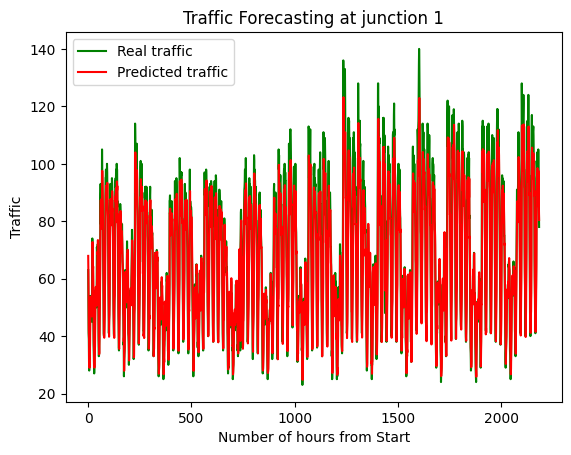

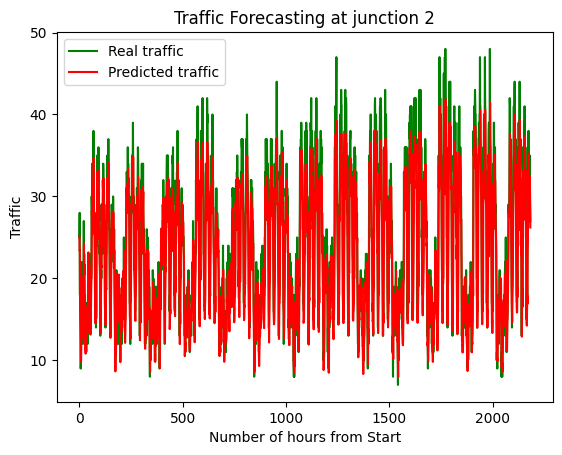

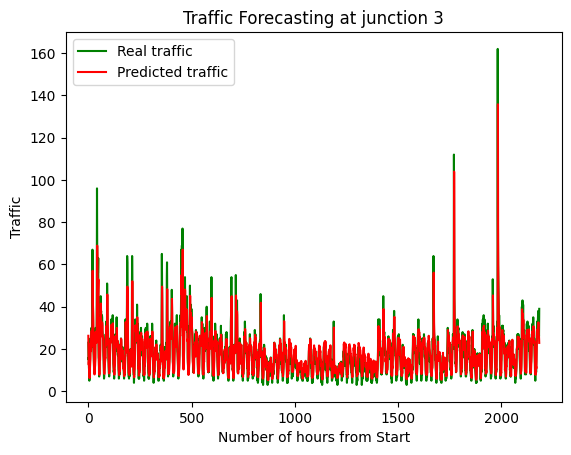

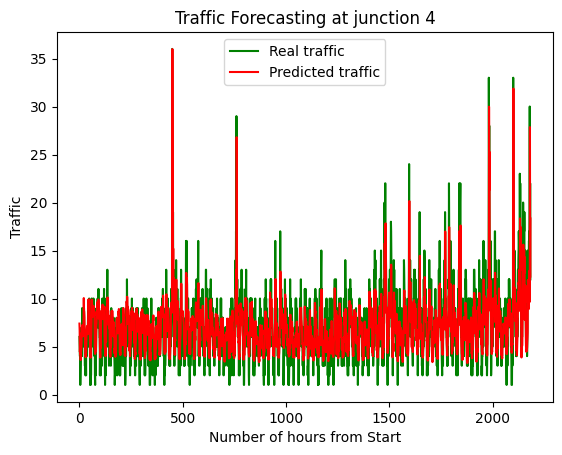

In [27]:
# Visualizing the data
# Visualising Result for the junctions
for junction in range(4):
    plt.figure
    plt.plot(y_truth.values[:,junction],color='green', label='Real traffic')
    plt.plot(y_pred[:,junction],color='red',label ='Predicted traffic')
    plt.title('Traffic Forecasting at junction %i' % (junction+1))
    plt.xlabel('Number of hours from Start')
    plt.ylabel('Traffic')
    plt.legend()
    plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true,y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [29]:
rmse(y_truth,y_pred)

5.930242456116397

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict on training data
pred = clf.predict(X_train.reshape(X_train.shape[0], -1))

# Calculate RMSE for each output
rmse_values = [np.sqrt(mean_squared_error(y_train[:, i], pred[:, i])) for i in range(y_train.shape[1])]
print("RMSE for RandomForest:", np.mean(rmse_values))


RMSE for RandomForest: 0.020709513877800557


In [48]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse1(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Calculate RMSE
rmse_value = rmse1(y_train, pred)
print("RMSE:", rmse_value)


RMSE: 0.02168492048645432


In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize DecisionTreeRegressor
DT = DecisionTreeRegressor()

# Fit the model
DT.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict on training data
pred2 = DT.predict(X_train.reshape(X_train.shape[0], -1))

# Calculate RMSE for each output
rmse_values = [np.sqrt(mean_squared_error(y_train[:, i], pred2[:, i])) for i in range(y_train.shape[1])]
print("RMSE for Decision Tree:", np.mean(rmse_values))


RMSE for Decision Tree: 0.01628410942748679


In [50]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize SVR and fit for each output
rmse_values = []
for i in range(y_train.shape[1]):
    SVR_model = SVR(kernel='linear')
    SVR_model.fit(X_train.reshape(X_train.shape[0], -1), y_train[:, i])
    pred3 = SVR_model.predict(X_train.reshape(X_train.shape[0], -1))
    rmse_value = np.sqrt(mean_squared_error(y_train[:, i], pred3))
    rmse_values.append(rmse_value)

print("RMSE for SVR:", np.mean(rmse_values))


RMSE for SVR: 0.06444041137524256


In [51]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize XGBRegressor
XGboost = XGBRegressor(objective="reg:squarederror", eval_metric="rmse", n_estimators=20, max_depth=10, random_state=42)

# Fit the model
XGboost.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict on training data
pred4 = XGboost.predict(X_train.reshape(X_train.shape[0], -1))

# Calculate RMSE for each output
rmse_values = [np.sqrt(mean_squared_error(y_train[:, i], pred4[:, i])) for i in range(y_train.shape[1])]
print("RMSE for XGBoost:", np.mean(rmse_values))


RMSE for XGBoost: 0.025990593745078682


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure you have computed these values
# Replace placeholders with actual values
val1 = np.sqrt(mean_squared_error(y_train, pred))  # RMSE for RandomForest
val2 = np.sqrt(mean_squared_error(y_train, pred2))  # RMSE for Decision Tree
val3 = np.sqrt(mean_squared_error(y_train, pred3))  # RMSE for SVM
val4 = np.sqrt(mean_squared_error(y_train, pred4))  # RMSE for XGBoost

# Create a list of RMSE values
frequencies = [val1, val2, val3, val4]
freq_series = pd.Series(frequencies)

x_labels = ['RF', 'DT', 'SVM', 'XGBoost']

# Plot the figure
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar', color='skyblue')

ax.set_title('Evaluation of ML Models')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_xticklabels(x_labels, rotation=0)

def add_value_labels(ax, spacing=5):
    # For each bar: Place a label
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.2f}".format(y_value)
        # Create annotation
        ax.annotate(label,
                    (x_value, y_value),
                    xytext=(0, space),
                    textcoords="offset points",
                    ha='center',
                    va=va)

# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.show()


ValueError: y_true and y_pred have different number of output (4!=1)

In [57]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.svm import SVR

# Assuming you are using SVR for each output; create and train SVR models separately for each output
# Example for training SVR models for each output
svr_models = [SVR() for _ in range(y_train.shape[1])]
for i, model in enumerate(svr_models):
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train[:, i])

# Predicting with SVR models
pred3 = np.column_stack([model.predict(X_train.reshape(X_train.shape[0], -1)) for model in svr_models])

# Calculate RMSE for each model
def calculate_rmse(y_true, y_pred):
    rmse_values = [np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i])) for i in range(y_true.shape[1])]
    return np.mean(rmse_values)

# Predictions for each model
# For RandomForest
pred = clf.predict(X_train.reshape(X_train.shape[0], -1))  # Ensure this is 2D
val1 = calculate_rmse(y_train, pred)

# For Decision Tree
pred2 = DT.predict(X_train.reshape(X_train.shape[0], -1))  # Ensure this is 2D
val2 = calculate_rmse(y_train, pred2)

# For SVM
pred3 = np.column_stack([model.predict(X_train.reshape(X_train.shape[0], -1)) for model in svr_models])  # Ensure this is 2D
val3 = calculate_rmse(y_train, pred3)

# For XGBoost
pred4 = XGboost.predict(X_train.reshape(X_train.shape[0], -1))  # Ensure this is 2D
val4 = calculate_rmse(y_train, pred4)


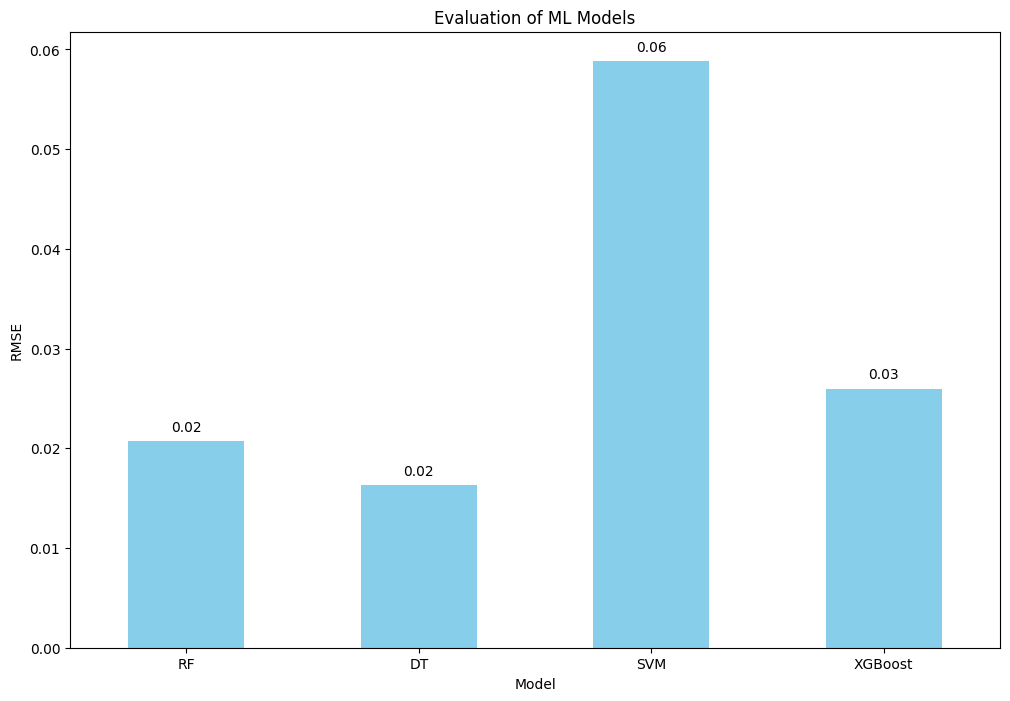

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure you have computed these values
# Replace placeholders with actual values
frequencies = [val1, val2, val3, val4]
freq_series = pd.Series(frequencies)

x_labels = ['RF', 'DT', 'SVM', 'XGBoost']

# Plot the figure
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar', color='skyblue')

ax.set_title('Evaluation of ML Models')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_xticklabels(x_labels, rotation=0)

def add_value_labels(ax, spacing=5):
    # For each bar: Place a label
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.2f}".format(y_value)
        # Create annotation
        ax.annotate(label,
                    (x_value, y_value),
                    xytext=(0, space),
                    textcoords="offset points",
                    ha='center',
                    va=va)

# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.show()


In [63]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

# Define a simplified SVR pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', MultiOutputRegressor(SVR()))
])

# Simplified parameter grid for quicker results
param_grid = {
    'svr__estimator__kernel': ['linear'],  # Reduced to one kernel
    'svr__estimator__C': [1],  # Single value for C
    'svr__estimator__epsilon': [0.1]  # Single value for epsilon
}

# Setup GridSearchCV with fewer folds and parallel processing
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)

# Optionally use a smaller subset of data for quicker results
# X_train_sample = X_train[:1000]
# y_train_sample = y_train[:1000]
# grid_search.fit(X_train_sample.reshape(X_train_sample.shape[0], -1), y_train_sample)

# Fit GridSearchCV with the full data
grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Output best parameters and RMSE
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters: {'svr__estimator__C': 1, 'svr__estimator__epsilon': 0.1, 'svr__estimator__kernel': 'linear'}
Best RMSE: 0.1061734236844996


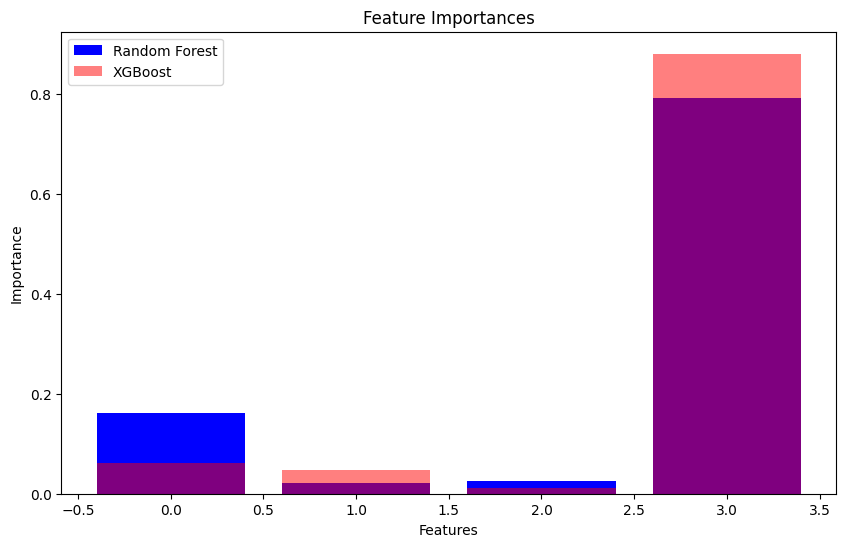

In [64]:

# Feature importance for Random Forest and XGBoost
importances_rf = clf.feature_importances_
importances_xgb = XGboost.feature_importances_

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances_rf)), importances_rf, color='b', label='Random Forest')
plt.bar(range(len(importances_xgb)), importances_xgb, color='r', label='XGBoost', alpha=0.5)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.show()

# Documenting and reporting
# Create a detailed report and prepare visualizations for presentation

